In [194]:
import pandas as pd
import pylab as plt
%matplotlib inline
import numpy as np
import math

df=pd.read_csv('data/train.csv', sep=',')

features = ['Fare_s','Sex_', 'Pclass_s', 'Age_s','HasAge','Parch_s']
#features = ['Sex_', 'Age_s_e']

from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression(C=0.5, random_state=0)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(9,include_bias=False)

from sklearn.metrics import accuracy_score

## Transform features

In [195]:
def feature_engineering(df):
    df['Sex_'] = df['Sex'].apply(lambda x: 0 if x=='female' else 1)
    
    df['Fare'] = df['Fare'].fillna(10)
    df['Fare'] = df['Fare'].apply(lambda x: 40 if x > 40 else x)
    
    fareMax=df['Fare'].max()
    fareMin=df['Fare'].min()

    df['Fare_s'] = (df['Fare']-fareMin)/(fareMax-fareMin)
    
    df['Pclass_s'] = df['Pclass']/3
    
    df['SibSp'] = df['SibSp'].apply(lambda x: 3 if x > 3 else x)
    df['SibSp_s'] = df['SibSp']/df['SibSp'].max()
    
    df['Parch'] = df['Parch'].apply(lambda x: 3 if x > 3 else x)
    df['Parch_s'] = df['Parch']/df['Parch'].max()

    df['HasAge'] = df['Age'].apply(lambda x: 0 if np.isnan(x) else 1)

    df['Age_'] = df['Age'].fillna(30)
    df['Age_'] = df['Age_'].apply(lambda x: 0 if x <= 16 else x)
    df['Age_'] = df['Age_'].apply(lambda x: 22 if x >12 and x <= 29 else x)
    df['Age_'] = df['Age_'].apply(lambda x: 40 if x >29 and x <= 46 else x)
    df['Age_'] = df['Age_'].apply(lambda x: 60 if x >46 else x)
    ageMax=df['Age_'].max()
    ageMin=df['Age_'].min()

    df['Age_s'] = (df['Age_']-ageMin)/(ageMax-ageMin)
    
    
    df['Age_with_Sex'] = df['Age_s'] + df['Sex_']

feature_engineering(df)



## Study Model

In [196]:
def correct_rate(lr_model):
    correct_rate = 0.0
    correct_rate_train = 0.0

    number_run = 100
    for i in range(number_run):

        msk = np.random.rand(len(df)) < 0.8
        _train = df[msk]
        _validation = df[~msk]

        X_train = _train[features]
        X_train = poly.fit_transform(X_train)


        lr_model.fit(X_train ,_train['Survived'])

        X_validation = _validation[features]
        X_validation = poly.fit_transform(X_validation)

        #predict = lr_model.predict(X_validation)

        #correct_rate += accuracy_score(_validation['Survived'],predict)
        correct_rate += lr_model.score(X_validation, _validation['Survived'])
        correct_rate_train += lr_model.score(X_train, _train['Survived'])

    correct_rate = correct_rate/number_run
    correct_rate_train = correct_rate_train/number_run

    return (correct_rate, correct_rate_train)

In [198]:
correct_rate(lr_model)

(0.82337106450701114, 0.84949178492709521)

## Good results above

## Choosing C:

In [199]:
C_para, score = [], []

for c in np.arange(-5, 3):
    lr = LogisticRegression(C=10**c, random_state=0)
    rate = correct_rate(lr)
    C_para.append(10**c)
    score.append(rate)

score = np.array(score)


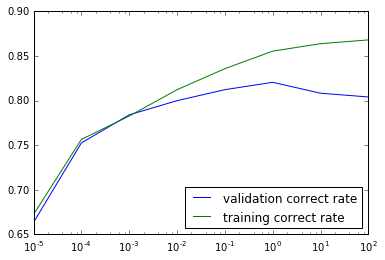

In [200]:
plt.plot(C_para, score[:,0], label='validation correct rate')
plt.plot(C_para, score[:,1], label='training correct rate')
plt.legend(loc='lower right')
plt.xscale('log')

## Train Model

In [201]:
X = df[features]
X = poly.fit_transform(X)

lr_model.fit(X ,df['Survived'])

LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [202]:
pre = lr_model.predict(X)
1 - (pre != df['Survived']).sum()/float(len(df))

0.856341189674523

In [203]:
print len(lr_model.coef_[0])

5004


In [208]:
print X.shape

(891, 5004)


## Predict test

In [204]:
test = pd.read_csv('data/test.csv', sep=',')

feature_engineering(test)

X_test = test[features]
X_test = poly.fit_transform(X_test)



test['Survived'] = lr_model.predict(X_test)

In [205]:
import csv as csv
predictions_file = open("LRmodel.Od9.C0.5.csv", "wb")
predictions_file_object = csv.writer(predictions_file)
predictions_file_object.writerow(["PassengerId", "Survived"])	# write the column headers
for index, row in test.iterrows():									# For each row in test file,
    predictions_file_object.writerow([row['PassengerId'], row['Survived']])			# write the PassengerId, and predict 1
predictions_file.close()